# Generate Trainning/Testing Data (normal distribution)

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import sklearn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [112]:
sampled_data = []
matching_parameters = []
MIN_N = 10e1
MAX_N = 10e2
MAX_MEAN = 10000
MAX_SD = 1000

for i in range(0,100):
    n = np.random.randint(MIN_N, MAX_N)
    mean = np.random.randint(0, MAX_MEAN)/100.0
    sd = np.random.randint(0,MAX_SD)/100.0
    values = np.random.normal(mean, sd, n)
    sampled_data.append(values)
    matching_parameters.append([mean, sd, n])
    

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 2., 0., 0., 0., 1.,
        2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
        0., 1., 0., 2., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 2., 1., 1., 2., 1., 0., 2., 0., 1., 1., 0., 2., 1., 1.,
        0., 1., 1., 2., 1., 3., 1., 1., 2., 0., 3., 1., 3., 0., 1., 0., 1.,
        1., 3., 1., 1., 0., 0., 2., 2., 3., 1., 1., 0., 3., 2., 0., 2., 1.,
        2., 

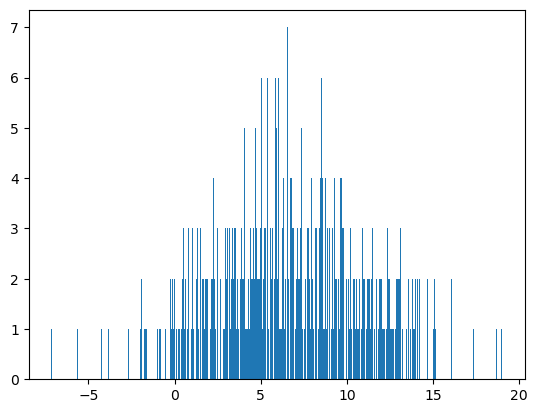

In [113]:
plt.hist(sampled_data[0],matching_parameters[0][2])

## Summary Stats

In [114]:
summary_stats = []
for i in range(0,len(sampled_data)):
    #take elementwise average of each sample distribution
    summary = []        # will contain [average, n]
    summary.append(np.sum(sampled_data[i])/matching_parameters[i][2])
    summary.append(matching_parameters[i][2])
    
    #predict mean first, remove irrelevant parameters
    matching_parameters[i].pop(1)
    matching_parameters[i].pop(1)
    summary_stats.append(summary)

## Split into test & train data

In [115]:
x,y = np.array(summary_stats), np.array(matching_parameters)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [135]:
y_train = y_train.reshape(-1, 1)
y_test = y_test

In [136]:
class Data(Dataset):
  def __init__(self, X: np.ndarray, y: np.ndarray) -> None:
    self.X = torch.from_numpy(X.astype(np.float32))
    self.y = torch.from_numpy(y.astype(np.float32))
    self.len = self.X.shape[0]
    
  def __getitem__(self, index: int) -> tuple:
    return self.X[index], self.y[index]

  def __len__(self) -> int:
        return self.len

In [137]:
train_data = Data(x_train, y_train)
test_data = Data(x_test, y_test)

In [138]:
print(train_data[1])

(tensor([ 41.3671, 679.0000]), tensor([41.4600]))


In [139]:
batch_size = 10
num_workers = 4

#load data
train_loader = DataLoader(train_data, 
                         batch_size=batch_size, 
                         shuffle=True, 
                         num_workers=num_workers)

## Linear Regression

In [140]:
class LinearRegression(nn.Module):
  def __init__(self, input_dim: int, 
               hidden_dim: int, output_dim: int) -> None:
    super(LinearRegression, self).__init__()
    self.input_to_hidden = nn.Linear(input_dim, hidden_dim)
    self.hidden_layer_1 = nn.Linear(hidden_dim, hidden_dim)
    self.hidden_layer_2 = nn.Linear(hidden_dim, hidden_dim)
    self.hidden_to_output = nn.Linear(hidden_dim, output_dim)
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.input_to_hidden(x)
    x = self.hidden_layer_1(x)
    x = self.hidden_layer_2(x)
    x = self.hidden_to_output(x)
    return x

In [141]:
input_dim = x_train.shape[1]
hidden_dim = 2
model = LinearRegression(input_dim, hidden_dim, 1)


In [142]:
print(model)

LinearRegression(
  (input_to_hidden): Linear(in_features=2, out_features=2, bias=True)
  (hidden_layer_1): Linear(in_features=2, out_features=2, bias=True)
  (hidden_layer_2): Linear(in_features=2, out_features=2, bias=True)
  (hidden_to_output): Linear(in_features=2, out_features=1, bias=True)
)


## Loss function & Optimiser

In [143]:
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

## Trainning

In [152]:
epochs = 100
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        #inputs, labels = data
        # forward propagation
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        # set optimizer to zero grad
        # to remove previous epoch gradients
        optimizer.zero_grad()
        # backward propagation
        loss.backward()
        # optimize
        optimizer.step()
        running_loss += loss.item()
      # display statistics
    if not ((epoch + 1) % (epochs // 10)):
        print(f'Epochs:{epoch + 1:5d} | ' \
              f'Batches per epoch: {i + 1:3d} | ' \
              f'Loss: {running_loss / (i + 1):.10f}')

RuntimeError: torch_shm_manager at "/Users/User/anaconda3/lib/python3.11/site-packages/torch/bin/torch_shm_manager": could not generate a random directory for manager socket